In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

4.2 多层感知机

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [3]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True)*0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True)*0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [4]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [5]:
def net(X):
    X = X.reshape(-1, num_inputs)
    H = relu(X @ W1 + b1)
    return (H @ W2 + b2)

In [6]:
loss = nn.CrossEntropyLoss()

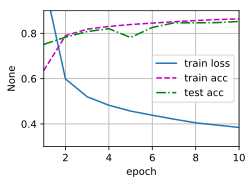

In [7]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

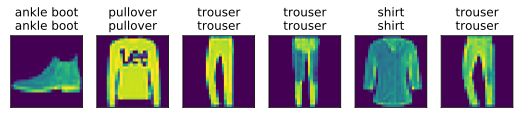

In [8]:
d2l.predict_ch3(net, test_iter)

4.3多层感知机的简洁实现

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

In [10]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
                   nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

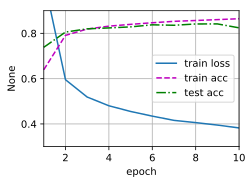

In [11]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

4.6 Dropout

In [12]:
def dropout_layer(X, dropout):
    assert 0<= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    return mask*X/(1.0-dropout)

In [13]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  0.,  0.,  8.,  0., 12.,  0.],
        [ 0.,  0.,  0.,  0., 24., 26.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [14]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

In [15]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.linear1 = nn.Linear(num_inputs, num_hiddens1)
        self.linear2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.linear3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        H1 = self.relu(self.linear1(X.reshape(-1, self.num_inputs)))
        if self.training:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.linear2(H1))
        if self.training:
            H2 = dropout_layer(H2, dropout2)
        out = self.relu(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)        

4.6.简单实现

In [25]:
net = nn.Sequential(nn.Flatten(), nn.Linear(num_inputs, num_hiddens1),nn.ReLU(),nn.Dropout(),
                    nn.Linear(num_hiddens1, num_hiddens2),nn.ReLU(),nn.Dropout(),
                    nn.Linear(num_hiddens2, num_outputs))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

In [26]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)

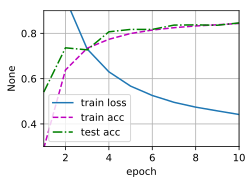

In [27]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)